# Домашнее задание №2 - Линейные модели. Градиентный спуск

В этом домашнем задании мы с вами научимся обучать линейные модели регрессии и классификации при помощи очень мощного, но в то же время довольно понятного алгоритма, который называется **градиетный спуск**. Помимо линейных моделей он используется и для обучения самых сложных нейронных сетей! Также мы потренируемся применять готовые реализации линейных моделей для задач регрессии и бинарной классификации.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                             confusion_matrix, 
                             roc_curve,
                             accuracy_score, 
                             precision_score, 
                             recall_score, 
                             f1_score,
                             roc_auc_score,
                             ConfusionMatrixDisplay)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

#### Маленькое теоретическое отступление

Основное свойство антиградиента (-1 * градиент) &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента, пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (коэффициентов линейной модели) ((например, нулевой или сгенерированный из некоторого, случайного распределения)). Тогда обычный градиентный спуск состоит в повторении следующих шагов до сходимости:


$$
    w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}),
$$

где $\nabla_{w} Q(w_{k})$ &ndash; градиент функции потерь в точке $w_k$, а $\eta$ &ndash; скорость обучения (learning rate).

Градиентный спуск обычно останавливают, когда прошло заданное максимальное количество итераций или когда графиент близок к нулю (т.е. наши параметры практически не меняются). Для реализации второго варианта считают норму градиента (по сути длину вектора). Это можно сделать несколькими способами:

$$
l1_{norm} = \sum{|w_i|}
$$

$$
l2_{norm} = \sum{(w_i)^{2}}
$$

Попробуем разобраться на простом примере. Рассмотрим функцию от двух переменных:
$f(x, y) = \sin^2 x + \sin^2 y$

In [3]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

Обратите внимание, что $x$ - numpy-array вектор длины 2.

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $w_1$ и $w_2$ такие, что при них значение $f(w_1, w_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

### Задание 1. Градиентный спуск для функции $f$ (1 балл)

Реализуйте функцию, которая будет осуществлять градиентный спуск для функции $f$:

*Примечание:* Вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

In [4]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    grad = np.array([2 * np.sin(w[0]) * np.cos(w[0]), 2 * np.sin(w[1]) * np.cos(w[1])])
    return grad

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение

In [5]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [6]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr*grad_f(curr_w)

    return np.vstack(history)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $w_1, w_2, f(w_1, w_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму (Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_w_1, cur\_w_2, f(cur\_w_1, cur\_w_2)$ в `steps` в процессе спуска).

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точек минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [7]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

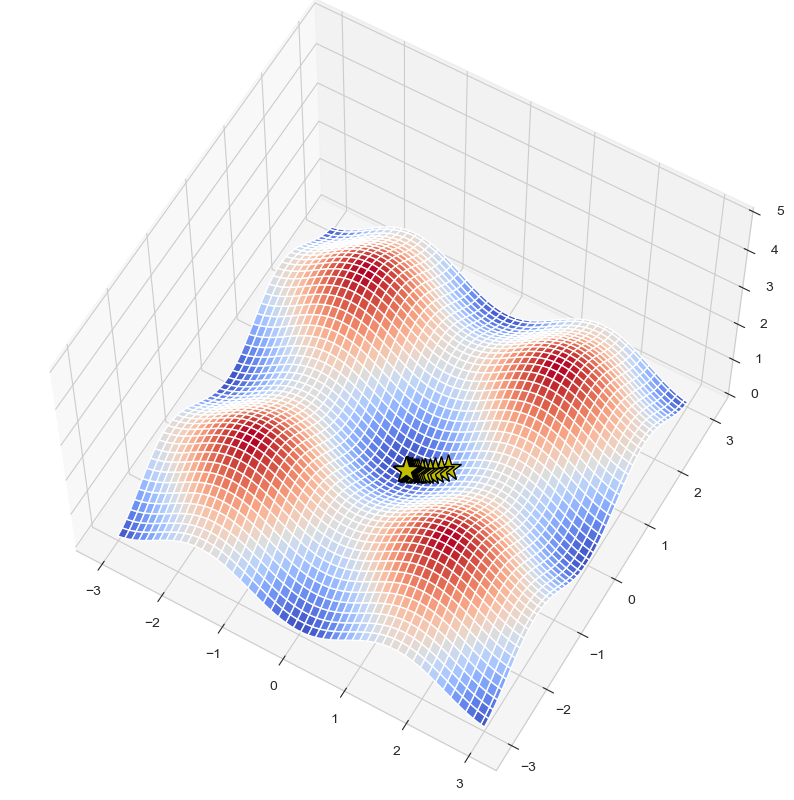

In [8]:
steps = gradient_desc_vis(f, grad_f)

Посмотрим на зависимость значения функции от шага градиентного спуска.

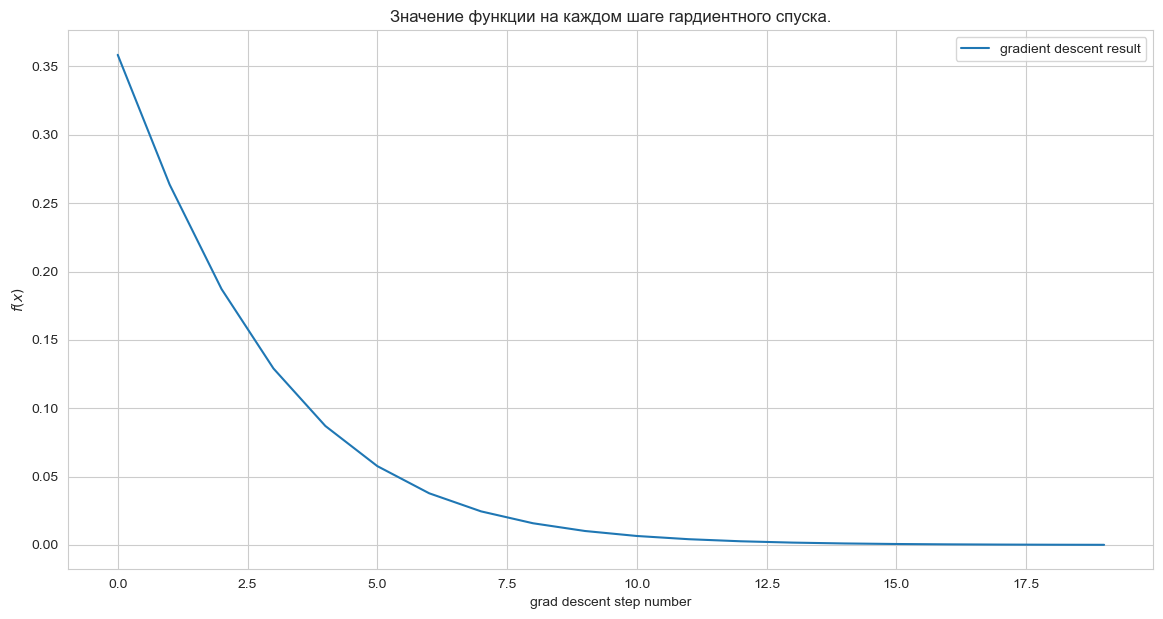

In [9]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге гардиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

### Задание 2. Реализация линейной регресии (суммарно 9 баллов)

Так как мы будем использовать градиентный спуск для обучения модели, важной часть является реализация функции потерь и функции для расчета ее градиента. Перем началом стоит напомнить, как считать градиент MSE. Вывод этой формулы можно найти  [здесь](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
    MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
    \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

Здесь имеется в виду именно матричное умножение.

#### Задание 2.1. MSE и ее градиент (2 балла)

In [10]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
        
    return np.mean((y_true - y_pred) ** 2)


def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    n_samples = y_true.shape[0]
    grad = (2/n_samples) * X.T.dot(y_pred - y_true)
    return grad


class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [11]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

В данном задании нужно будет реализовать линейную регрессию и обучить ее при помощи градиентного спуска. Для этого нужно будет заполнять пропуски кода в соответствующих классах. Для начала мы реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий. Не переживайте, этот класс уже реализован, вам достостаточно просто разобраться с кодом.

In [12]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

#### Задание 2.2. Предсказания линейной регрессии (3 балла)

Реализуйте метод `predict` у класса `CustomLinearRegression`, не забудьте про свободный член!

In [13]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]

        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))

        y_pred = X_test.dot(self.W) 
        
        return y_pred
        
    
    
    def __repr__(self):
        return "My custom linear regression"

##### Проверим нашу реализацию на простом примере

In [14]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

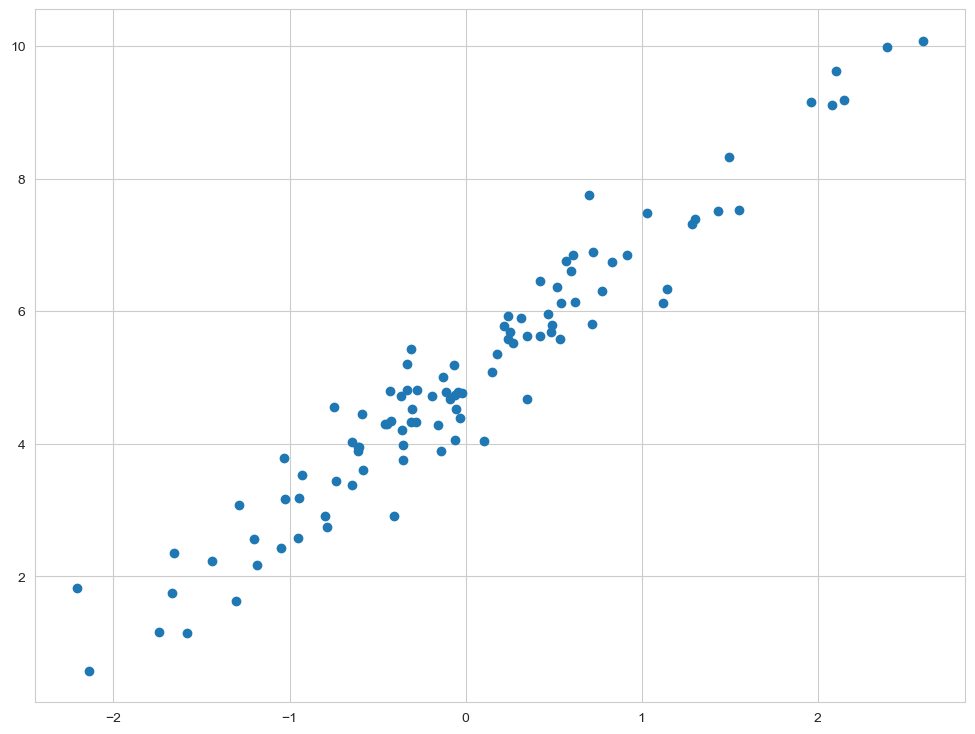

In [15]:
plt.scatter(X, y);

In [16]:
custom_lin_reg = CustomLinearRegression()

In [17]:
custom_lin_reg.fit(X, y)

My custom linear regression

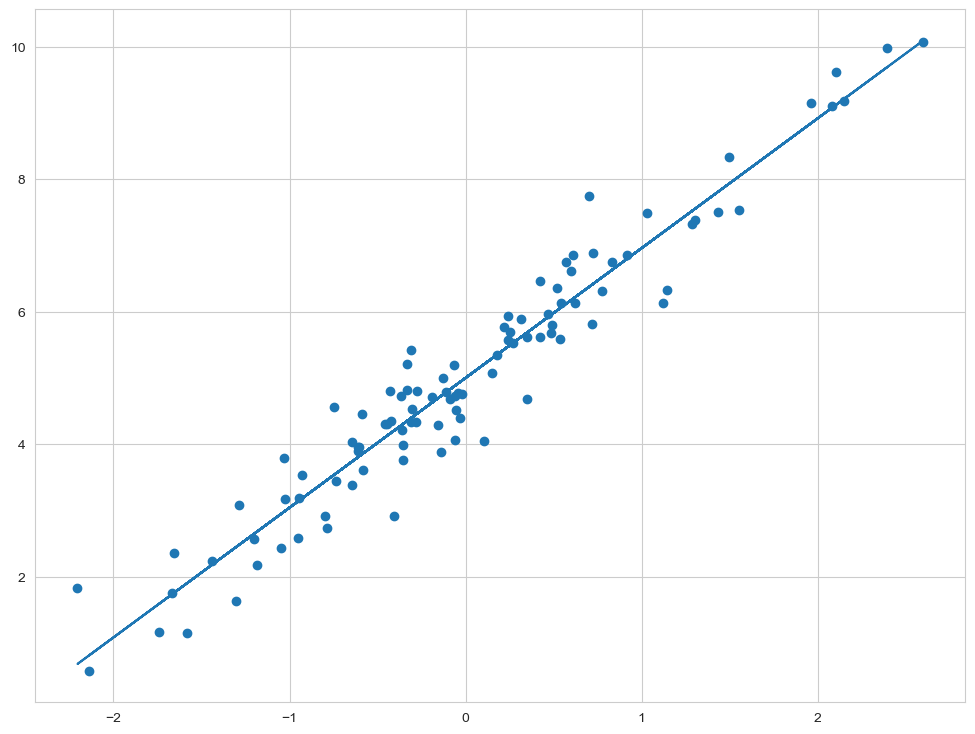

In [18]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X));

#### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

Поработаем с данными о ценах на дома в Калифорнии. Постройте модель линейной регресии при помощи `LinearRegression` из `sklearn`. Не забудьте разделить данные на тренировочную и тестовую части, а также правильно предобработать признаки. В конце воспользуйтесь какими-то изученными метриками регресии и сделайте выводы о качестве полученной модели, а также о том, какие признаки наиболее важны с точки зрения полученной модели.

In [19]:
data = fetch_california_housing()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

Ваш ход:

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.15,
                                                    random_state=SEED)

In [21]:
feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [22]:
#Стандартизация признаков (они все колличественные)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
#Создание и обучение модели
my_model = LinearRegression()
my_model.fit(X_train_scaled, y_train)

LinearRegression()

In [24]:
#Оценим качество с помощью R-squred и среднеквадратичной ошибки
y_pred = my_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.5404489359938611
R^2 Score: 0.5952907696388137


In [25]:
importance = my_model.coef_
for i, name in enumerate(feature_names):
    print(f"{name}: {importance[i]}")

MedInc: 0.8279990051707794
HouseAge: 0.12008753469852754
AveRooms: -0.2604825638607621
AveBedrms: 0.3038744311436443
Population: -0.006106609431728569
AveOccup: -0.03944725181197221
Latitude: -0.8933656646590715
Longitude: -0.8614584371848129


**Выводы о полученной модели:**

Наиболее важными признаками, влияющими на среднюю стоимость дома, оказались MedInc, Latitude и Longitude, причем связь с признаком MedInc прямая: чам больше MedInc, тем выше target. C признаками Latitude и Longitude связь обратная.

Значение R2 оказалось 0.595, а MSE 0.54. Если сравнивать полученный R2 c 1, а MSE с 0, то в целом можно было бы и лучше наверное. 
Если на аналогичных данных построить KNN, то у него R2 будет выше, а MSE - ниже, что говорит о том, что такая модель как будто бы лучше.

### Задание 3. Реализация логистической регресии (суммарно 10 баллов)

Логистическая регрессия не очень сильно отличается от обычной линейной регрессии и используется в задах классификации. Так как здесь мы снова будем пользоваться градиентным спуском, то нужно определить функцию потерь и ее градиент. Одним из самых популярных вариантов в задаче бинарной классификации является бинарная кросс-энтропия (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Единственная проблема данной функции это возможность получить 0 под знаком логарифма, что не очень хорошо. Попробуем справить с этим "в лоб". Скажем, что наши предсказания могут принимать значения от 0 + eps до 1 - eps, где eps очень маленькое число.

#### Задание 3.1. Реализация сигмоиды (0.5 баллов)

Реализуйте функцию `sigmoid`, которая переводит действительное число $\mathbb R$ в вероятность $[0,1]$.

In [26]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)

    return 1 / (1 + np.exp(-output))

#### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

Так как мы с вами только начинаем изучать машинное обучение, то было бы слишком жестоко просить вас вычислить градиент BCE Loss (он не так сложен, просто нужно привыкнуть). Поэтому сразу напишем формулу для него:

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$

In [27]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)

    bce_loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    return bce_loss
    
   

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
    
    gradient = np.dot(X.T, (y_pred - y_true))
    
    return gradient
        

class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

#### Задание 3.3. Предсказания логистической регрессии (2 балла)

Реализуйте метод `predict` у класса `CustomLogisticRegression`, не забудьте про свободный член!

In [28]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        linear_combination = np.dot(X_test, self.W)
        probabilities = sigmoid(linear_combination)
    
        return probabilities
    
    
    def __repr__(self):
        return "My custom logistic regression"

#### Снова проверим работу алгоритма на простом примере

In [29]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

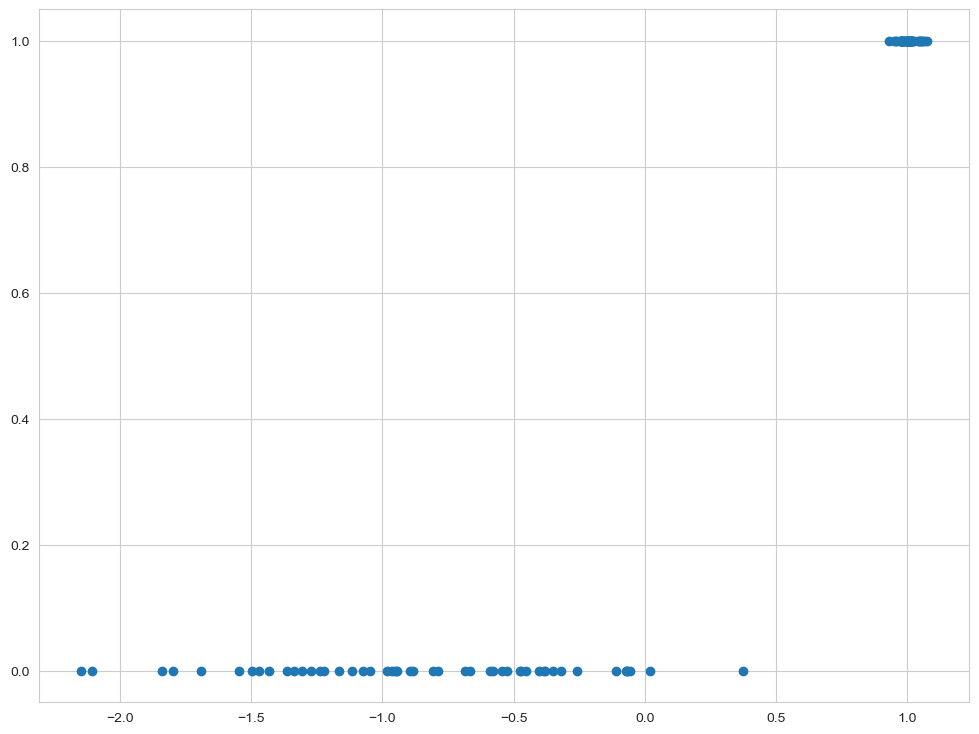

In [30]:
plt.scatter(X, y);

In [31]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

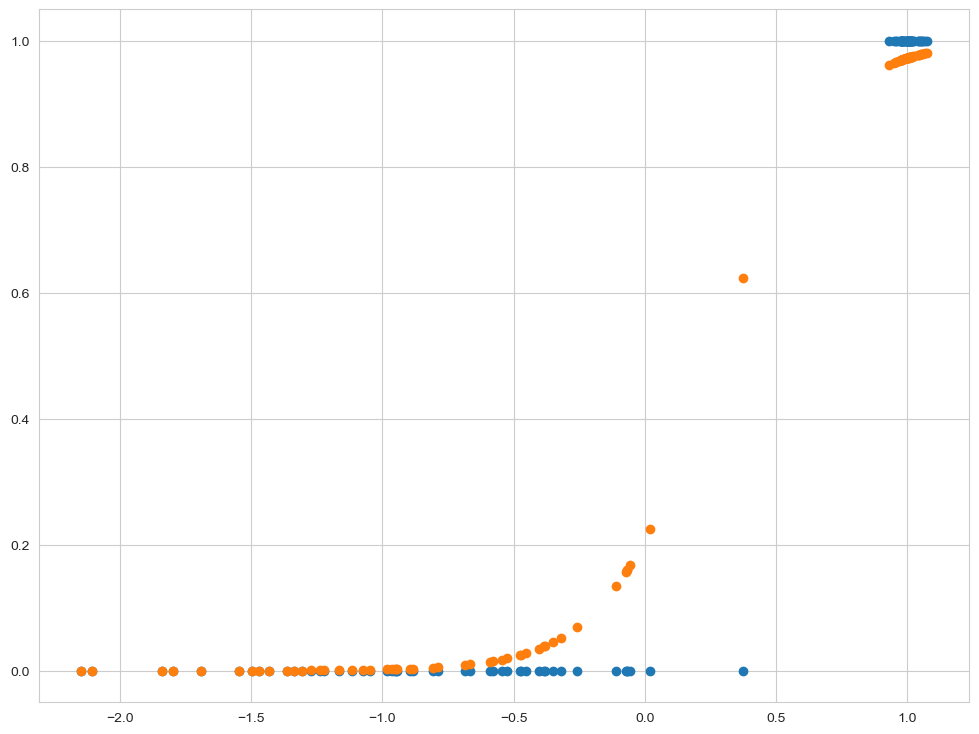

In [32]:
plt.scatter(X, y)
plt.scatter(X, y_pred);

Проверьте качество работы модели при помощи известных вам метрик бинарной классификации.

In [33]:
y_pred_labels = (y_pred >= 0.5).astype(int)

accuracy = accuracy_score(y, y_pred_labels)
precision = precision_score(y, y_pred_labels)
recall = recall_score(y, y_pred_labels)
f1 = f1_score(y, y_pred_labels)


print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.99
Precision: 0.9803921568627451
Recall: 1.0
F1 Score: 0.99009900990099


Для пороговой вероятности 0.5 для разделения на 2 класса модель работает хорошо.

#### Задание 3.4. Применение логистической регрессии (5 баллов)

Мы будем использовать данные по свойствам покемонов (https://www.kaggle.com/abcsds/pokemon). В данном задании вам необходимо сначала сделать краткий EDA (Посмотреть на данные и их распределения, а также посмотреть, как различные признаки связаны между собой и с целевой переменной (`Legendary`)).

In [34]:
pokemon = pd.read_csv("../data/Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


**EDA**

In [35]:
pokemon.shape #В данных всего 11 признаков и 800 наблюдений

(800, 13)

In [36]:
pokemon.info() #Из 11 признаков 3 (Name, Type 1, Type 2 - категориальные, остальные - количественные)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In [37]:
missing_values = pokemon.isnull().sum()
missing_values #В нашем датасете есть 386 пропущенных значений для признака Type2. 
#Возможно я не буду использовать его для предсказания, так как 386 пропусков из 800 - это очень много.


#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [38]:
descriptive_stats = pokemon.describe()
descriptive_stats

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,362.813750,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,208.343798,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,1.000000,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,184.750000,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,364.500000,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,539.250000,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,721.000000,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


In [39]:
categorical_features = ['Type 1', 'Type 2', 'Generation']
categories_info = {}

for feature in categorical_features:
    categories = pokemon[feature].dropna().unique()
    categories_info[feature] = {
        'total_categories': len(categories),
        'categories': categories
    }

categories_info #Всего в данных 18 уникальных основных типов и 18 вторичных типов и 6 возможных поколений.

{'Type 1': {'total_categories': 18,
  'categories': array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
         'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
         'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)},
 'Type 2': {'total_categories': 18,
  'categories': array(['Poison', 'Flying', 'Dragon', 'Ground', 'Fairy', 'Grass',
         'Fighting', 'Psychic', 'Steel', 'Ice', 'Rock', 'Dark', 'Water',
         'Electric', 'Fire', 'Ghost', 'Bug', 'Normal'], dtype=object)},
 'Generation': {'total_categories': 6,
  'categories': array([1, 2, 3, 4, 5, 6], dtype=int64)}}

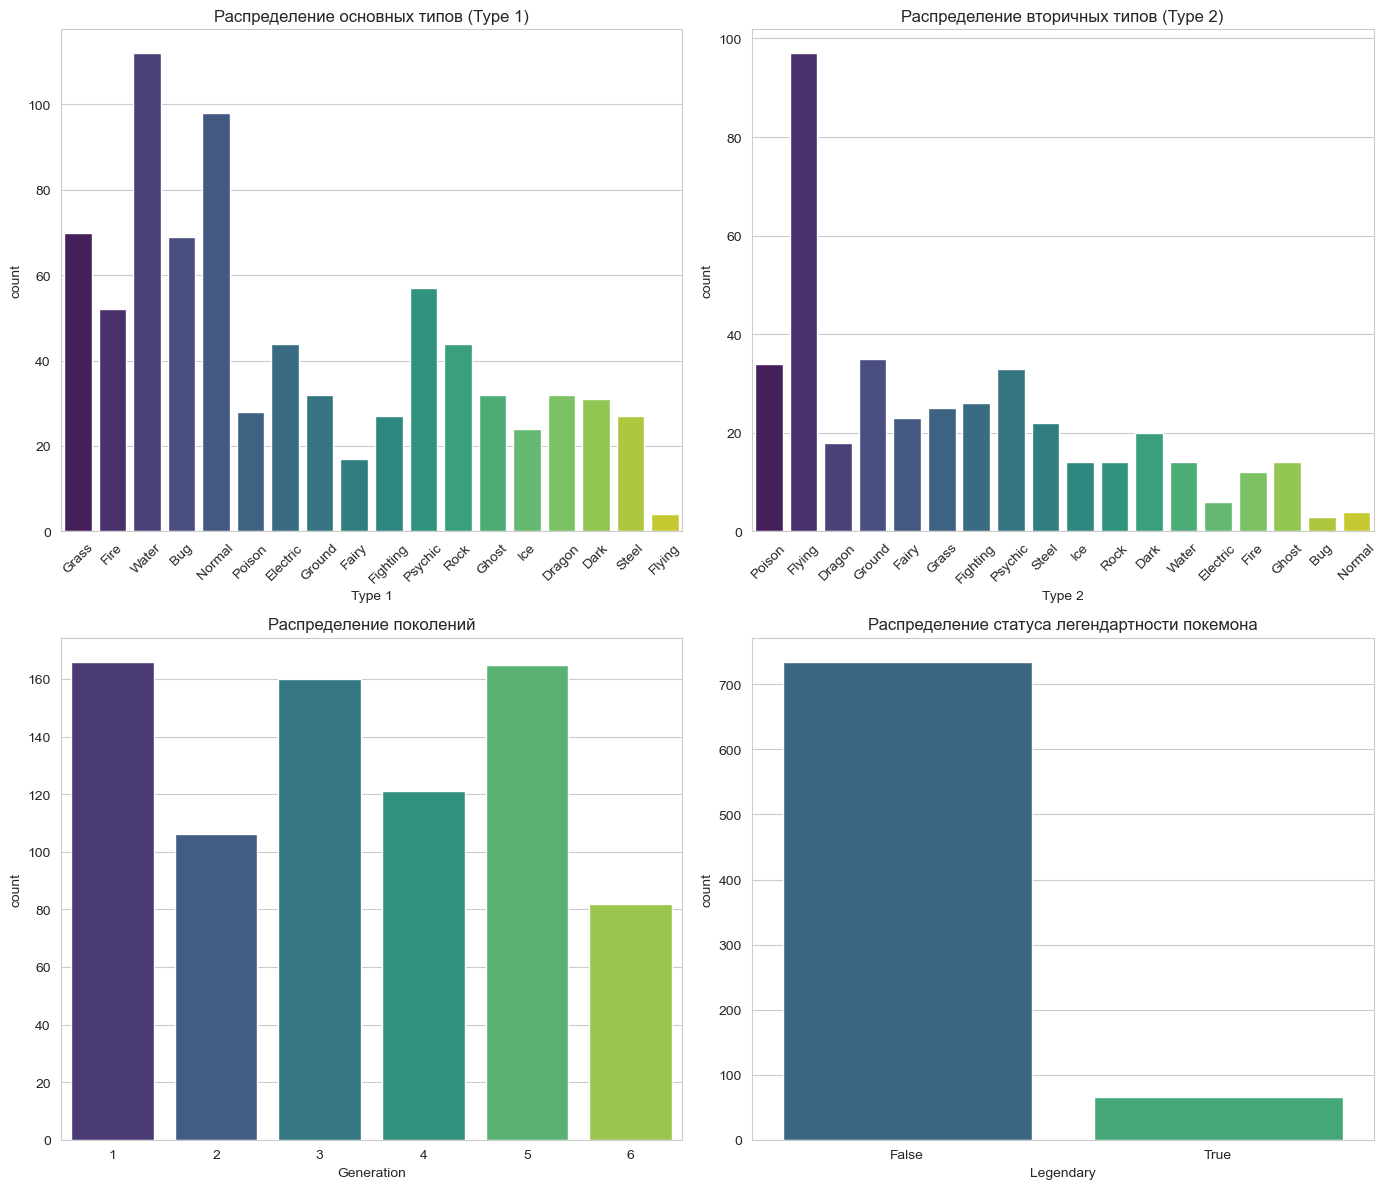

In [40]:
# Установка стиля для графиков
sns.set_style("whitegrid")

# Распределение категориальных признаков: Type 1, Type 2, Generation и Legendary
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Распределение по основному типу
sns.countplot(ax=axes[0, 0], x='Type 1', data=pokemon, palette='viridis')
axes[0, 0].set_title('Распределение основных типов (Type 1)')
axes[0, 0].tick_params(axis='x', rotation=45)

# Распределение по вторичному типу
sns.countplot(ax=axes[0, 1], x='Type 2', data=pokemon, palette='viridis')
axes[0, 1].set_title('Распределение вторичных типов (Type 2)')
axes[0, 1].tick_params(axis='x', rotation=45)

# Распределение по поколениям
sns.countplot(ax=axes[1, 0], x='Generation', data=pokemon, palette='viridis')
axes[1, 0].set_title('Распределение поколений')

# Распределение легендарных и не легендарных покемонов
sns.countplot(ax=axes[1, 1], x='Legendary', data=pokemon, palette='viridis')
axes[1, 1].set_title('Распределение статуса легендартности покемона')

plt.tight_layout()
plt.show()


Видно, что нелегендарных покемонов сильно больше, чем легендарных.
Типы покемонов также распределены неравномерно. Среди основных типов, такие типы, как Water и Normal, являются наиболее часто встречающимися, в то время как другие, например, Fairy и Ice, встречаются реже.

По поколениям покемоны распределены относительно равномерно с самым меньшим числом покемонов, относящимся к поколению 6.

In [41]:
type_1_legendary_breakdown = pokemon.groupby(['Type 1', 'Legendary']).size().unstack(fill_value=0)
type_1_legendary_breakdown


Legendary,False,True
Type 1,,
Bug,69,0
Dark,29,2
Dragon,20,12
Electric,40,4
Fairy,16,1
Fighting,27,0
Fire,47,5
Flying,2,2
Ghost,30,2


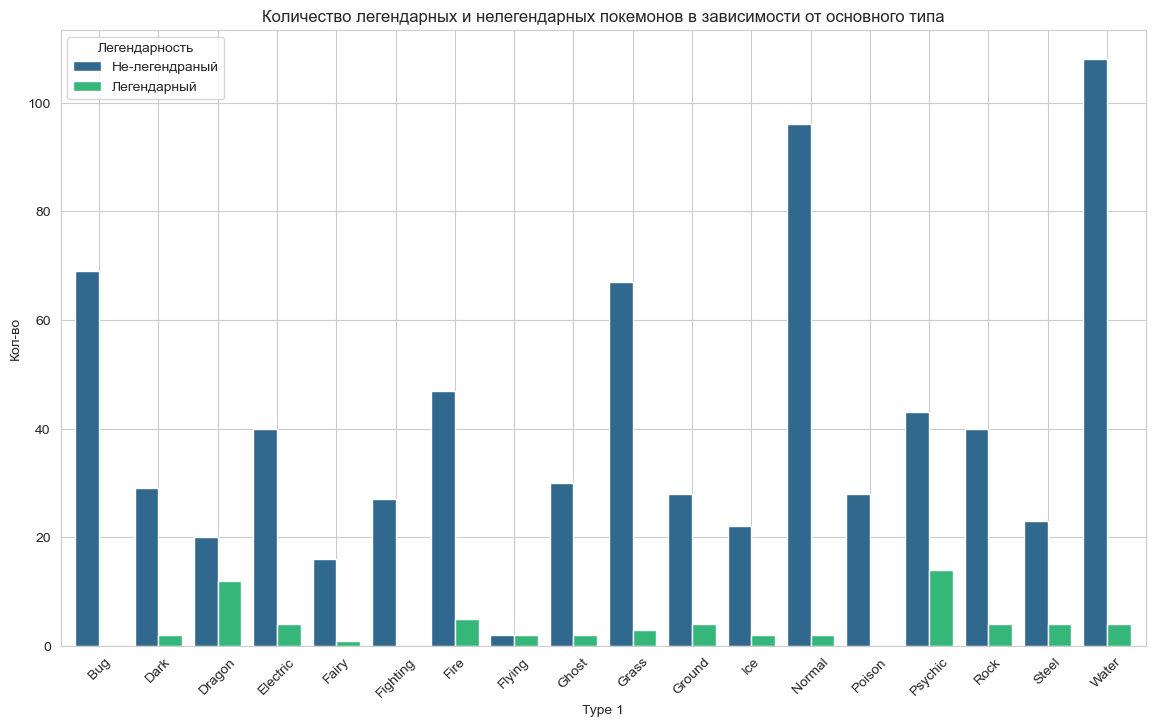

In [42]:
viridis_palette = sns.color_palette("viridis", 2)
type_1_legendary_breakdown.plot(kind='bar', figsize=(14, 8), width=0.8, color=viridis_palette)
plt.title('Количество легендарных и нелегендарных покемонов в зависимости от основного типа')
plt.xlabel('Type 1')
plt.ylabel('Кол-во')
plt.xticks(rotation=45)
plt.legend(title='Легендарность', labels=['Не-легендраный', 'Легендарный'])
plt.show()



Видно, что среди самого частого основного типа покемонов (Water), количество легендарных покемонов непропроционально низкое. При этом для основного типов Dragon или Psychic, которых достаточно мало, доля легендарных покемонов относительно высокая. Или, например, в типе flying (которого очень мало) все покемоны - легендарные.

Поэтому тип покемона (Type 1) важный признак и я буду учитывать его в построении модели. При этом Type 2 я учитывать не буду, потому что там слишком много пропущенных значений. 

In [43]:
#Распределение легендарных и нелегендарных покемонов по поколениям
generation_legendary_breakdown = pokemon.groupby(['Generation', 'Legendary']).size().unstack(fill_value=0)
generation_legendary_proportion = generation_legendary_breakdown.div(generation_legendary_breakdown.sum(axis=1), axis=0)
generation_legendary_proportion.iloc[:, 1]*100  #% легендарных покемонов от общего числа покемонов в каждом поколении

Generation
1     3.614458
2     4.716981
3    11.250000
4    10.743802
5     9.090909
6     9.756098
Name: True, dtype: float64

Здесь видно, что доля легендарных покемонов в 1-2 поколении почти в 2 раза ниже, чем в 3,4,5 или 6 поколениях. Поэьтому это может быть важный признак для предсказания легендарности покемонов.

**Корреляционный анализ количественных переменных**

C:\Users\User\AppData\Local\Temp\ipykernel_1556\3353116402.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = pokemon.corr()


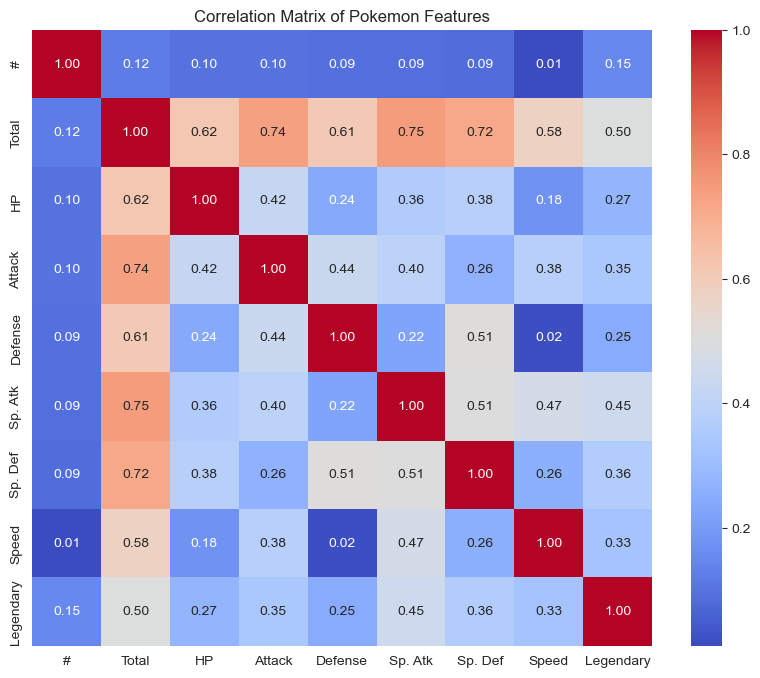

In [44]:
pokemon['Generation'] = pokemon['Generation'].astype('category') #преобразует Generation в категорию
pokemon['Legendary'] = pokemon['Legendary'].astype(int) #преобразует Legendary в числа 1 и 0
correlation_matrix = pokemon.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Pokemon Features')
plt.show()

Целевая переменная Legendary имеет наиболее высокую положительную корреляцию с Total, Sp. Atk (Специальная атака) и Sp. Def (Специальная защита). Это указывает на то, что легендарные покемоны в среднем имеют более высокие общие характеристики и силу в специальных атаках и защите.

Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

Я не стала выбрасывать Type 1 и Generation, потому что, судя по графиками, они существенно влияют на легендарность покемона. Я воспользуюсь One-hot encoding, чтобы перекодировать эти переменные.

Разделите ваши данные на тестовую и тренировочную выборку.

In [45]:
# Подготовка данных для модели
# Выбросим столбец с именами покемонов и ID , так как они не несут полезной информации для предсказания. 
# Еще выбросим Type 2
pokemon_data_for_model = pokemon.drop(['#', 'Name', 'Type 2'], axis=1)

# One-hot encoding для категориальных признаков
encoder = OneHotEncoder(sparse=False, drop='first') 
categorical_features = ['Type 1', 'Generation']
encoded_features = encoder.fit_transform(pokemon_data_for_model[categorical_features])

# Создаем DataFrame для закодированных признаков
encoded_features_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))

# Удаляем исходные категориальные столбцы и добавляем закодированные
pokemon_data_for_model = pokemon_data_for_model.drop(categorical_features, axis=1)
pokemon_data_for_model = pd.concat([pokemon_data_for_model, encoded_features_df], axis=1)

quantitative_features = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']

# Разделение данных на тренировочную и тестовую выборку
X = pokemon_data_for_model.drop('Legendary', axis=1)
y = pokemon_data_for_model['Legendary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[quantitative_features] = scaler.fit_transform(X_train[quantitative_features])
X_test_scaled[quantitative_features] = scaler.transform(X_test[quantitative_features])

X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape


c:\Users\User\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((640, 29), (160, 29), (640,), (160,))

Обучите модель `LogisticRegression` из `sklearn`.

In [46]:
# Обучение модели логистической регрессии 
model_log_reg = LogisticRegression(max_iter=1000)
model_log_reg.fit(X_train_scaled, y_train)

# Предсказание
y_pred = model_log_reg.predict(X_test_scaled)
y_pred_proba = model_log_reg.predict_proba(X_test_scaled)[:, 1]

Выведите метрики вашего классификатора:

1. Нарисуйте [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Изобразите ROC кривую и посчитайте площадь под ней.

3. Скажите, какие признаки оказались наиболее важны для модели.

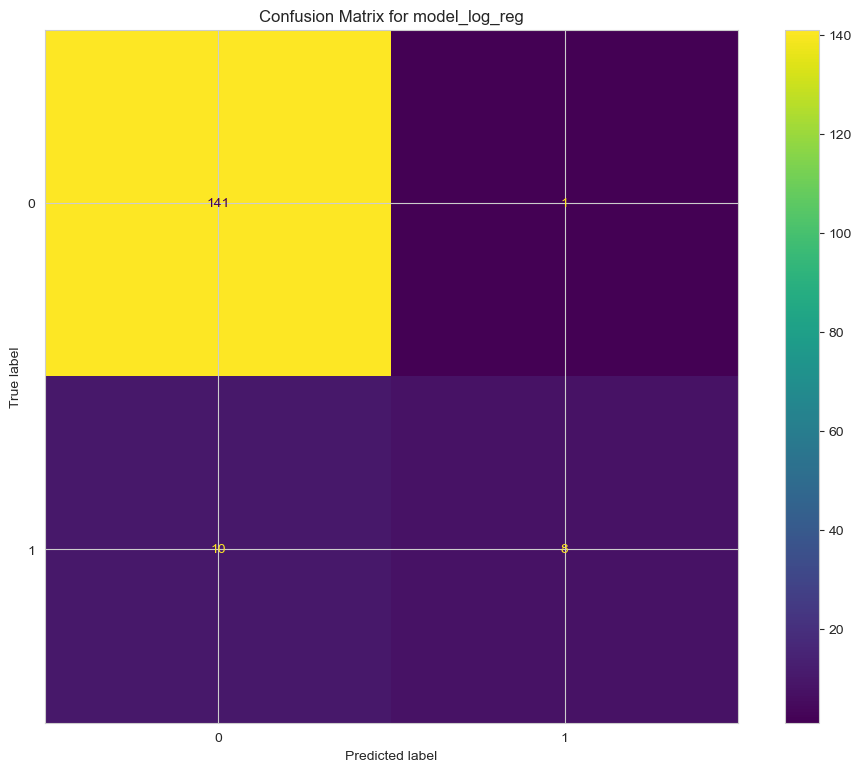

In [47]:
#Confusion matrix 

# Построение Confusion Matrix
cm_model_log_reg = confusion_matrix(y_test, y_pred)
disp_model_log_reg = ConfusionMatrixDisplay(confusion_matrix=cm_model_log_reg, display_labels=model_log_reg.classes_)
disp_model_log_reg.plot(cmap='viridis')
plt.title('Confusion Matrix for model_log_reg')
plt.show()


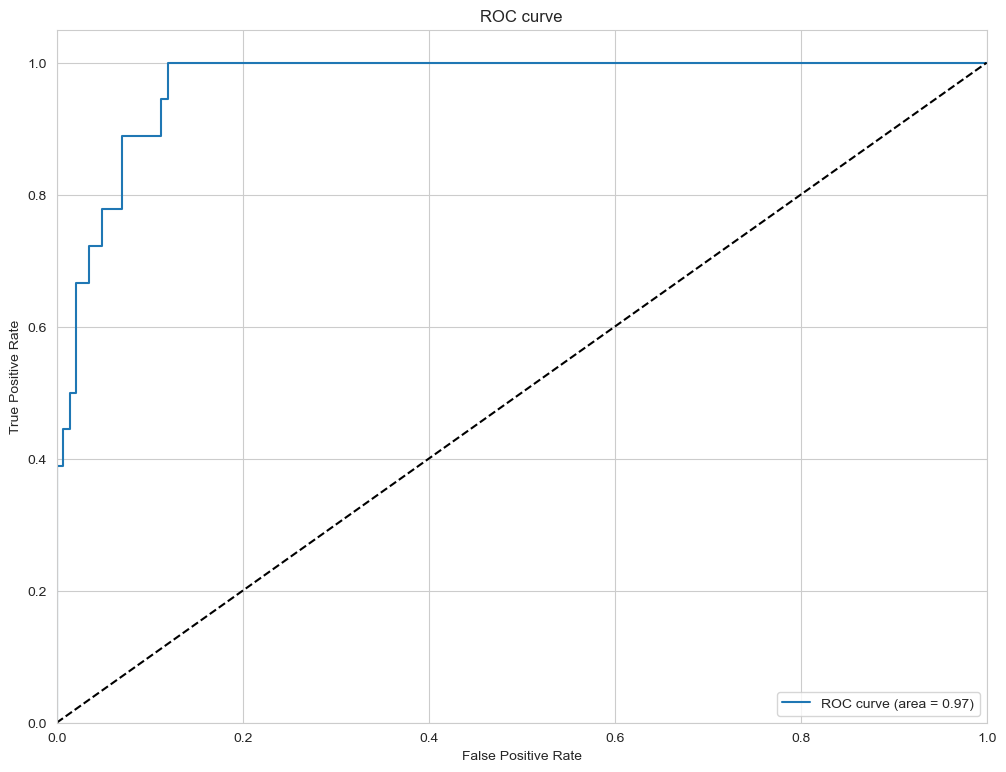

In [48]:
# ROC кривая и площадь под ней
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [49]:
# Важность признаков
feature_importance = abs(model_log_reg.coef_[0])
features = np.array(X_train_scaled.columns)
indices = np.argsort(feature_importance)[::-1]

# Вывод наиболее важных признаков
print("Feature ranking:")
for f in range(X_train_scaled.shape[1]):
    print(f"{f + 1}. feature {features[indices[f]]} ({feature_importance[indices[f]]:.4f})")

Feature ranking:
1. feature Generation_5 (1.3153)
2. feature Total (1.1081)
3. feature Speed (1.0391)
4. feature Type 1_Water (0.9475)
5. feature Sp. Def (0.9417)
6. feature Sp. Atk (0.8727)
7. feature Type 1_Ground (0.8408)
8. feature Type 1_Psychic (0.8010)
9. feature Type 1_Normal (0.7744)
10. feature Generation_6 (0.7426)
11. feature Type 1_Flying (0.7286)
12. feature Defense (0.7156)
13. feature Type 1_Ice (0.6401)
14. feature Generation_2 (0.6357)
15. feature Generation_4 (0.5537)
16. feature HP (0.5370)
17. feature Type 1_Steel (0.4355)
18. feature Type 1_Dragon (0.4209)
19. feature Generation_3 (0.3909)
20. feature Type 1_Fighting (0.3735)
21. feature Type 1_Dark (0.3290)
22. feature Attack (0.3251)
23. feature Type 1_Electric (0.1808)
24. feature Type 1_Rock (0.1757)
25. feature Type 1_Grass (0.1230)
26. feature Type 1_Poison (0.0632)
27. feature Type 1_Ghost (0.0554)
28. feature Type 1_Fire (0.0402)
29. feature Type 1_Fairy (0.0147)


Модель нормальная, хорошо описывает данные. Сonfusion matrix показывает, что true positive rate довольно высокий.
Площадь под ROC-кривой приблизительно равна 0.97, что достаточно близко к 1 и тоже хорошо, т.к. модель может с высокой точностью различать легендарных и нелегендарных покимонов. Наиболее значимыми признакми для модели для определения легендарности покемона стали Generation и Total.


### Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

Расскажите, как вы познакомились с этой группой и скиньте несколько наиболее любимых треков)

Самое сложное задание из всей домашки. 
Выбрать всего лишь ОДНУ любимую музыкальную группу.
Пускай будет System Of A Down.
Познакомилась я с ними случайно лет в 11-12, когда слушала плейлист старшей сестры в контактике и натнулась на них. С тех пор люблю всем сердцем, была на их концерте в 2015 году в Олимпийском (он еще тогда был).
Любимые 3 песни (но вообще все):

[Harakiri](https://www.youtube.com/watch?v=PQtRXqBQETA)

[Psyco](https://www.youtube.com/watch?v=ZsHOnGF6_8Y)

[Question](https://www.youtube.com/watch?v=ENBv2i88g6Y)

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**